In [63]:
from IPython.core.display import Image
import sys

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

In [64]:
def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date, api_key='2gwP5WpwYPiHshKy1H9v')\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date', 'symbol'])
        out = pd.concat([out, df], axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO','AMZN','YHOO','MSFT'],data_source='quandl',begin_date='2012-01-01',end_date=None)
# note, we're only using real price data to get an accurate date/symbol index set.  

print(prices.head())

                         open        high         low       close      volume
date       symbol                                                            
2012-01-03 AAPL     52.613606   53.011999   52.562200   52.848787  75555200.0
           AMZN    175.890000  179.475000  175.550000  179.030000   5110800.0
           CSCO     15.550278   15.810147   15.491597   15.617341  41236600.0
           MSFT     22.609162   22.958305   22.472910   22.792249  64731500.0
           YHOO     16.270000   16.390000   16.200000   16.285000  19708600.0


In [65]:
num_obs = prices.close.count()

def add_memory(s, n_days=50, memory_strength=0.1):
    ''' adds autoregressive behavior to series of data'''
    add_ewm = lambda x: (1 - memory_strength)*x + memory_strength*x.ewm(n_days).mean()
    out = s.groupby(level='symbol').apply(add_ewm)
    return out

# generate feature data
f01 = pd.Series(np.random.randn(num_obs),index=prices.index)
f01 = add_memory(f01,10,0.1)
f02 = pd.Series(np.random.randn(num_obs),index=prices.index)
f02 = add_memory(f02,10,0.1)
f03 = pd.Series(np.random.randn(num_obs),index=prices.index)
f03 = add_memory(f03,10,0.1)
f04 = pd.Series(np.random.randn(num_obs),index=prices.index)
f04 = f04 # no memory

## now, create response variable such that it is related to features
# f01 becomes increasingly important, f02 becomes decreasingly important,
# f03 oscillates in importance, f04 is stationary, finally a noise component is added

outcome =   f01 * np.linspace(0.5,1.5,num_obs) + \
            f02 * np.linspace(1.5,0.5,num_obs) + \
            f03 * pd.Series(np.sin(2*np.pi*np.linspace(0,1,num_obs)*2)+1,index=f03.index) + \
            f04 + \
            np.random.randn(num_obs) * 3 
outcome.name = 'outcome'

In [34]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = pd.concat([f01,f02,f03,f04],axis=1)
features.columns = ['f01','f02','f03','f04']
model.fit(X=features, y=outcome)
print('RSQ: '+str(model.score(X=features,y=outcome)))
print('Regression Coefficients: '+str(model.coef_))

RSQ: 0.2714559391939636
Regression Coefficients: [0.95289547 1.04495616 1.01053158 1.02582927]


In [35]:
split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = LinearRegression()
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(model.score(X=X_train,y=y_train)))
print('RSQ out of sample: '+str(model.score(X=X_test,y=y_test)))
print('Regression Coefficients: '+str(model.coef_))

RSQ in sample: 0.30211092681558027
RSQ out of sample: 0.10894885629166662
Regression Coefficients: [0.88207985 1.15107011 1.222187   1.03126413]


In [36]:
recalc_dates = features.resample('Q',level='date').mean().index
#print('recalc_dates:')
#print(recalc_dates)
#print()

models = pd.Series(index=recalc_dates)

for date in recalc_dates:
    X_train = features.xs(slice(None,date), level='date', drop_level=False)
    y_train = outcome.xs(slice(None,date), level='date', drop_level=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    models.loc[date] = model
    
    print("Training on the first {} records, through {}"\
          .format(len(y_train),y_train.index.get_level_values('date').max()))
    #print("Coefficients: {}".format((model.coef_)))
    #print()

Training on the first 310 records, through 2012-03-30 00:00:00
Training on the first 625 records, through 2012-06-29 00:00:00
Training on the first 940 records, through 2012-09-28 00:00:00
Training on the first 1250 records, through 2012-12-31 00:00:00
Training on the first 1550 records, through 2013-03-28 00:00:00
Training on the first 1870 records, through 2013-06-28 00:00:00
Training on the first 2190 records, through 2013-09-30 00:00:00
Training on the first 2510 records, through 2013-12-31 00:00:00
Training on the first 2815 records, through 2014-03-31 00:00:00
Training on the first 3130 records, through 2014-06-30 00:00:00
Training on the first 3450 records, through 2014-09-30 00:00:00
Training on the first 3770 records, through 2014-12-31 00:00:00
Training on the first 4075 records, through 2015-03-31 00:00:00
Training on the first 4390 records, through 2015-06-30 00:00:00
Training on the first 4710 records, through 2015-09-30 00:00:00
Training on the first 5030 records, through

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


     2012-03-31
f01    0.198951
f02    1.207783
f03    1.394149
f04    1.021065
     2012-03-31  2012-06-30
f01    0.198951    0.676348
f02    1.207783    1.498619
f03    1.394149    1.775081
f04    1.021065    0.779180
     2012-03-31  2012-06-30  2012-09-30
f01    0.198951    0.676348    0.760171
f02    1.207783    1.498619    1.408917
f03    1.394149    1.775081    2.195594
f04    1.021065    0.779180    0.969133
     2012-03-31  2012-06-30  2012-09-30  2012-12-31
f01    0.198951    0.676348    0.760171    0.936903
f02    1.207783    1.498619    1.408917    1.248228
f03    1.394149    1.775081    2.195594    2.037843
f04    1.021065    0.779180    0.969133    0.918301
     2012-03-31  2012-06-30  2012-09-30  2012-12-31  2013-03-31
f01    0.198951    0.676348    0.760171    0.936903    0.496699
f02    1.207783    1.498619    1.408917    1.248228    1.226947
f03    1.394149    1.775081    2.195594    2.037843    1.785613
f04    1.021065    0.779180    0.969133    0.918301    1.033772


<AxesSubplot:title={'center':'Coefficients for Expanding Window Model'}>

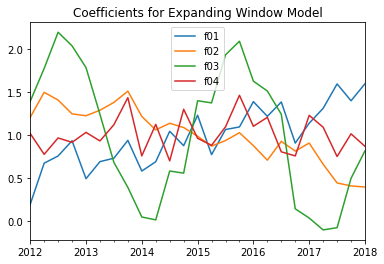

In [68]:
def extract_coefs(models):
    coefs = pd.DataFrame()
    for i, model in enumerate(models):
        model_coefs = pd.Series(model.coef_ ,index=['f01','f02','f03','f04']) #extract coefficients for model
        model_coefs.name = models.index[i] # name it with the recalc date
        coefs = pd.concat([coefs,model_coefs], axis=1)
        print(coefs.head())
    return coefs.T
extract_coefs(models).plot(title='Coefficients for Expanding Window Model')

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Training on the most recent 310 records
Coefficients: [-0.2907333  -0.29801174 -0.05873596  0.13768171]
Training on the most recent 315 records
Coefficients: [-0.05565922  0.14896566 -0.08107612 -0.02756593]
Training on the most recent 315 records
Coefficients: [-2.04377992e-04 -2.35691045e-01  6.06362213e-02  9.06499683e-02]
Training on the most recent 305 records
Coefficients: [ 0.00699984  0.33800308 -0.02830588  0.131651  ]
Training on the most recent 305 records
Coefficients: [-0.18277599 -0.04842589  0.21186684 -0.18789376]
Training on the most recent 320 records
Coefficients: [-0.0233859   0.05494367 -0.16120062  0.17493026]
Training on the most recent 315 records
Coefficients: [-0.35468259 -0.04053486  0.34045335  0.06452275]
Training on the most recent 315 records
Coefficients: [ 0.02519207 -0.08071104  0.3873246   0.1575784 ]
Training on the most recent 310 records
Coefficients: [ 0.02049277 -0.04554009 -0.06612187 -0.16865527]
Training on the most recent 315 records
Coeffici

[4 rows x 25 columns]


<AxesSubplot:title={'center':'Coefficients for Rolling Window Model'}>

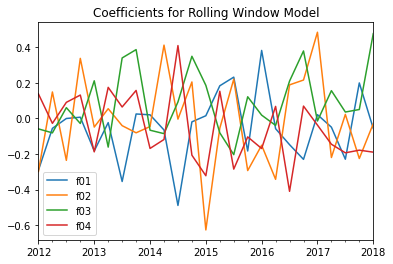

In [75]:
recalc_dates = features.resample('Q',level='date').mean().index

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models.loc[date] = model
    
    print("Training on the most recent {} records".format(len(y_train)))
    print("Coefficients: {}".format((model.coef_)))
    
extract_coefs(models).plot(title='Coefficients for Rolling Window Model')

In [86]:
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions = pd.Series(index=features.index)

for i,model in enumerate(models): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0:
        p = pd.Series(model.predict(X),index=X.index)
    predictions.loc[X.index] = p

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [88]:
models_expanding_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(None,date),level='date',drop_level=False)
    y_train = outcome.xs(slice(None,date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_expanding_window.loc[date] = model
    
models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('90 days'),date),level='date',drop_level=False)
    model = LinearRegression()
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
begin_dates = models.index
end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

predictions_expanding_window = pd.Series(index=features.index)
for i,model in enumerate(models_expanding_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0:
        p = pd.Series(model.predict(X),index=X.index)
    predictions_expanding_window.loc[X.index] = p
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    if X.shape[0] != 0:
        p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarnin

In [90]:
from sklearn.metrics import r2_score

common_idx = outcome.dropna().index.intersection(predictions_expanding_window.dropna().index)
rsq_expanding = r2_score(y_true = outcome[common_idx],y_pred=predictions_expanding_window[common_idx])
rsq_rolling = r2_score(y_true = outcome[common_idx],y_pred=predictions_rolling_window[common_idx])

print("Expanding Window RSQ: {}".format(round(rsq_expanding,3)))
print("Rolling Window RSQ: {}".format(round(rsq_rolling,3)))

Expanding Window RSQ: -0.002
Rolling Window RSQ: -0.016


In [91]:
from sklearn.tree import DecisionTreeRegressor

split_point = int(0.80*len(outcome))

X_train = features.iloc[:split_point,:] 
y_train = outcome.iloc[:split_point] 
X_test = features.iloc[split_point:,:] 
y_test = outcome.iloc[split_point:] 

model = DecisionTreeRegressor(max_depth=3)
model.fit(X=X_train,y=y_train)

print('RSQ in sample: '+str(round(model.score(X=X_train,y=y_train),3)))
print('RSQ out of sample: '+str(round(model.score(X=X_test,y=y_test),3)))

RSQ in sample: 0.008
RSQ out of sample: -0.008


In [92]:
recalc_dates = features.resample('Q',level='date').mean().index.values[:-1]

models_rolling_window = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train = features.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    y_train = outcome.xs(slice(date-pd.Timedelta('365 days'),date),level='date',drop_level=False)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train,y_train)
    models_rolling_window.loc[date] = model
    
predictions_rolling_window = pd.Series(index=features.index)
for i,model in enumerate(models_rolling_window): #loop thru each models object in collection
    X = features.xs(slice(begin_dates[i],end_dates[i]),level='date',drop_level=False)
    p = pd.Series(model.predict(X),index=X.index)
    predictions_rolling_window.loc[X.index] = p

common_idx = y_test.dropna().index.intersection(predictions_rolling_window.dropna().index)
rsq_rolling = r2_score(y_true = y_test[common_idx],y_pred=predictions_rolling_window[common_idx])
print("RSQ out of sample (rolling): {}".format(round(rsq_rolling,3)))

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()


RSQ out of sample (rolling): -0.035
